# Exercise 3 – Interpretation von Modellen

### Folgende Teilaufgaben beschreiben die Fragestellungen. Untersuchen Sie die Art der Variablen und die Verteilung der Zielvariablen. Gegebenenfalls ist eine Datenvorverarbeitung nötig. Nennen Sie die möglichen  Methoden.  Wählen  Sie  eine  Methode  aus  und  begründen  Sie  Ihre  Auswahl.  Bitte separieren  Sie  die  Datensätze  mit  80%  :  20%  =  Training  :  Test  und  führen  Sie  die  Methode  ohne Parameteroptimierung aus. Vergleichen Sie die Ergebnisse mit denen von vorgegebenen Methode(n).

### d) Schätzen  Sie  den  Anteil  des  Rohöls  im  Test-Datensatz,  das  in  Gasolin konvertiert  wird, anhand anderer Indikatoren im Datensatz `gasoline.csv`. Baseline: Beta Regression.

### Importieren der Bibliotheken

In [29]:
# Common Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Regression models
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge

# Evaluation
from sklearn.model_selection import cross_val_score, train_test_split  # cross validation

### Einlesen der Daten

Die Daten werden aus der Datei "gasoline.csv" gelesen. Die Spalten sind mit Semikola getrennt. Nachkommastellen sind mit Kommata von den Vorkommastellen getrennt. Die Namen der Spalten werden automatisch aus der Datei gelesen.

In [30]:
data = pd.read_csv('./data/gasoline.csv', sep=";", decimal=",")

### Vertrautmachen mit den Daten

In [31]:
print(data.shape) # print the number of rows and columns
print(data.dtypes) # print the data types of the columns
data = data.drop("Unnamed: 0", axis=1)

(32, 7)
Unnamed: 0      int64
yield         float64
gravity       float64
pressure      float64
temp10          int64
temp            int64
batch           int64
dtype: object


Die Daten umfassen 32 Einträge bei denen der Anteil von Rohöl annotiert ist, der in Benzin umgewandelt werden konnte. Dieser soll im Laufe der Aufgabe geschätzt werden. Die äußerst geringe Anzahl ein Einträgen macht die Vorhersage des Anteils voraussichtlich schwierig. Der Index wird verworfen, weil er im Folgenden nicht benötigt wird.

- Anteil des Rohöls, der in Benzin umgwandelt werden konnte (_Zielvariable_): Numerisch-Kontinuierlich zwischen 0 und 1
    - `yield`: Float
    
Erkärende Variablen des Rohöls:

- Gewicht: Numerisch-Kontinuierlich
    - `gravity`: Float

- Dampfdruck des Rohöls: Numerisch-Kontinuierlich
    - `pressure`: Float 

- Temperatur, an der 10 % des Rohöls verdampft ist, Numerisch-Diskret
    - `temp10`: Float

- Temperatur, an der alles Rohöls verdampft ist, Numerisch-Diskret
    - `temp`: Float
    
- Satzindikator, der die Konditionen des Gewichts, des Drucks und der 10% Temperatur beschreibt: Numerisch-Diskret
    - `batch`: Float

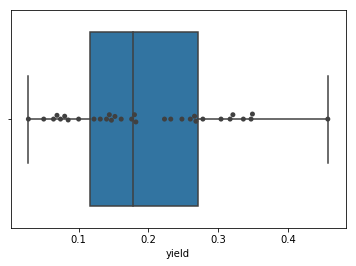

In [32]:
# print the boxplit of the crude oil percentage column with data points
ax = sns.boxplot(x="yield", data=data)
ax = sns.swarmplot(x="yield", data=data, color=".25")

Der Anteil variiert in einem Bereich zwischen 2,8 % bis 45,7 %. Auf diesem Intervall sind die Datenpunkte relativ gleichmäßig verteilt.

,yield,gravity,pressure,temp10,temp,batch
yield,1.000000,0.246326,0.384071,-0.315024,0.711526,-0.273302
gravity,0.246326,1.000000,0.620587,-0.700154,-0.321678,-0.760141
pressure,0.384071,0.620587,1.000000,-0.906225,-0.297984,-0.855971
temp10,-0.315024,-0.700154,-0.906225,1.000000,0.412247,0.976356
temp,0.711526,-0.321678,-0.297984,0.412247,1.000000,0.445989
batch,-0.273302,-0.760141,-0.855971,0.976356,0.445989,1.000000


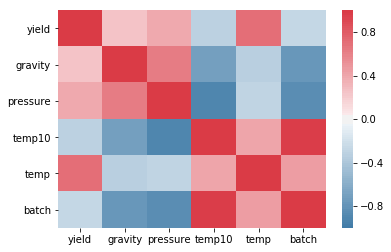

In [33]:
# Pearson Correlation
corr_pearson = data.corr('pearson')

cmap = sns.diverging_palette(240, 10, n=100)

sns.heatmap(corr_pearson, 
            xticklabels=corr_pearson.columns.values,
            yticklabels=corr_pearson.columns.values, cmap=cmap, vmin=-1, vmax=1);
corr_pearson

Es gibt in dem Datensatz viele hohe Korrelationen, insbesondere zwischen `temp` und `yield`. Die Temperatur dürfte deswegen eine wichtige Rolle als erklärende Variable spielen.

### Schätzen des Anteils an Rohöl

In [41]:
# split test and train set
data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 1)
X_train, y_train = data_train.values[:,1:], data_train.values[:,0] # define exogen and endogen
X_test, y_test = data_test.values[:,1:], data_test.values[:,0]

Die Beta-Regression wird mittels R umgesetzt. Dazu wird das Python-Paket rpy2, um im Notebook sowohl Python als auch R ausführen zu können.

In [42]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [59]:
%%R
# Install R package, if not already done
if(!require(betareg)){install.packages("betareg")}

In [67]:
%%R -i data_train -i data_test
# import data_train and data_test from global environment
set.seed(4040)
gy <- betareg(yield ~ gravity + pressure + temp10 + temp + batch, data=data_train)
response = predict(gy, newdata=data_test, type="response")
MSE <- mean((response - data_test$yield) * (response - data_test$yield))
RMSE <- sqrt(MSE)
print(RMSE)

In [68]:
from rpy2 import robjects
RMSE = robjects.r.RMSE
RMSE

0.038637


Das Modell der Beta-Regression wird auf den Trainingsdaten trainiert und auf den Testdaten getestet. Am Ende gilt es für die anderen Modelle die Baseline von 0.38637 zu schlagen.

In [72]:
def eval(model, model_name, X, y):
    scores = cross_val_score(model, X, y, cv=2, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    return "{}: RMSE {}, VAR {}".format(model_name, scores.mean(), scores.var())

In [73]:
print(eval(Lasso(),"Lasso", X_train, y_train))
print(eval(ElasticNet(),"ElasticNet", X_train, y_train))
print(eval(SVR(kernel="rbf", gamma=0.1),"SVM RBF", X_train, y_train))
print(eval(SVR(kernel="linear"),"SVM Linear", X_train, y_train))
print(eval(LinearRegression(),"LinearRegression", X_train, y_train))
print(eval(Ridge(),"RidgeRegression", X_train, y_train))

Lasso: RMSE 0.07010949353191717, VAR 8.940718302501124e-05
ElasticNet: RMSE 0.040802238095524274, VAR 2.7621600316803575e-07
SVM RBF: RMSE 0.0987457378051971, VAR 0.00043880946556397373
SVM Linear: RMSE 0.07722979765232739, VAR 0.0005269179029011813
LinearRegression: RMSE 0.031055333869264245, VAR 4.922119798805109e-06
RidgeRegression: RMSE 0.02604604819726553, VAR 4.120518146736717e-07


Die Ridge-Regression schlägt sich innerhalb des Trainingsdatensatz am besten.

In [78]:
ridge = Ridge().fit(X_train, y_train)
pred = ridge.predict(X_train)
MSE = np.mean((pred - y_train) * (pred - y_train))
RMSE = np.sqrt(MSE)
RMSE

0.021582103996745896

In [80]:
pred = ridge.predict(X_test)
MSE = np.mean((pred - y_test) * (pred - y_test))
RMSE = np.sqrt(MSE)
RMSE

0.017891728628449326

Auch gegen die Baseline schlägt sich die Ridge-Regression sehr gut.